# Kr analysis (MC)

In [1]:
from __future__ import print_function, division

import os
import operator
import functools
import copy
import time
import glob
print("Running on ", time.asctime())

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import invisible_cities.database.load_db as DB
import invisible_cities.core.system_of_units_c as SystemOfUnits
import invisible_cities.reco.pmaps_functions as pmapf
import invisible_cities.core.fit_functions as fitf

DataPMT = DB.DataPMT()
DataSiPM = DB.DataSiPM()
units = SystemOfUnits.SystemOfUnits()
pi = np.pi


Running on  Sun Mar 19 00:56:31 2017


#### General plotting options

In [2]:
plt.rcParams["figure.figsize"]          = 8, 6
plt.rcParams["font.size"]               = 15
plt.rcParams["figure.max_open_warning"] = 100

profOpt = "--k"
fitOpt  = "r"

outputfolder = "plots/effs"
if not os.path.exists(outputfolder):
    os.mkdir(outputfolder)

#### Useful functions

In [3]:
def lmap(*args):
    return list(map(*args))


def width(times, to_mus=False):
    """
    Compute peak width.
    """
    w = (np.max(times) - np.min(times)) if np.any(times) else 0.
    return w * units.ns/units.mus if to_mus else w


def timefunc(f):
    """
    Decorator for function timing.
    """
    def time_f(*args, **kwargs):
        t0 = time.time()
        output = f(*args, **kwargs)
        print("Time spent in {}: {} s".format(f.__name__,
                                              time.time() - t0))
        return output
    return time_f


def integrate_charge(d):
    """
    Integrate charge from a SiPM dictionary.
    """
    newd = dict((key, np.sum(value)) for key, value in d.items())
    return map(np.array, list(zip(*newd.items())))


def flat(nested_list):
    while hasattr(nested_list[0], "__iter__"):
        nested_list = [item for inner_list in nested_list for item in inner_list]
    return np.array(nested_list)


def labels(xlabel, ylabel):
    """
    Set x and y labels.
    """
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)


def plot(*args, **kwargs):
    """
    Create a figure and then plot
    """
    plt.figure()
    return plt.plot(*args, **kwargs)


def hist(*args, **kwargs):
    """
    Create a figure and then the histogram
    """
    plt.figure()
    return plt.hist(*args, **kwargs)

    
def hist2d(*args, **kwargs):
    """
    Create a figure and then the histogram
    """
    plt.figure()
    return plt.hist2d(*args, **kwargs)

    
def pdf(data, *args, **kwargs):
    """
    Create a normalized histogram with appropiate range.
    """
    data = np.array(data)
    h = hist(data, *args, **kwargs, weights=np.ones_like(data)/len(data))
    plt.yscale("log")
    plt.ylim(1e-4, 1.)
    return h
    
def scatter(*args, **kwargs):
    """
    Create a figure and then a scatter plot
    """
    plt.figure()
    return plt.scatter(*args, **kwargs)


def save_to_folder(outputfolder, name):
    """
    Set title and save plot in folder.
    """
    plt.title(name)
    plt.savefig("{}/{}.png".format(outputfolder, name), dpi=100)

save = functools.partial(save_to_folder, outputfolder)

### Input data

In [4]:
# Comment out this line if your data is in $IC_DATA
os.environ["IC_DATA"] = os.environ["IC_DATA"] + "/Kr2016/mar/"

pattern = "$IC_DATA/dst_NEXT_v0_08_09_Kr_ACTIVE_*_0_7bar_pmaps_10000.root.h5"
ifiles  = glob.glob(os.path.expandvars(pattern))
print("# files:", len(ifiles))
del ifiles[-2]

# files: 17


### Define event class

In [5]:
class Event:
    """
    Store for relevant event info.
    """
    def __init__(self):
        self.nS1   = 0
        self.S1w   = []
        self.S1h   = []
        self.S1i   = []

        self.nS2   = 0
        self.S2w   = []
        self.S2h   = []
        self.S2i   = []

        self.Nsipm = []
        self.Q     = []
        self.Qsipm = []
        self.Xt    = np.nan
        self.Yt    = np.nan
        self.X     = np.nan
        self.Y     = np.nan
        self.Xrms  = np.nan
        self.Yrms  = np.nan
        self.Z     = np.nan
        self.R     = np.nan
        self.Phi   = np.nan

        self.ok    = False

### Define dataset class

In [6]:
def get(attr):
    return lambda x: getattr(x, attr)

class Dataset:
    """
    Trick for accesing event properties as an attribute of the dataset.
    """
    def __init__(self, evts):
        self.evts = np.array(evts, dtype=object)
        self._create_attrs()
    
    @timefunc
    def _create_attrs(self):
        for attr in filter(lambda x: not x.endswith("__"), Event().__dict__):
            setattr(self, attr, np.array([getattr(evt, attr) for evt in self.evts]))

    def __getitem__(self, sel):
        return Dataset(self.evts[sel])

## Functions to fill the event and dataset classes

In [7]:
@timefunc
def fill_evts(s1s, s2s, sis, evts_out, ifile=None):    
    evts = set(list(s1s.keys()) +
               list(s2s.keys()) +
               list(sis.keys()))
    nevt = len(evts)
    print(ifile, nevt)
    for i, evt_number in enumerate(evts):
        evt = Event()
        s1  = s1s.get(evt_number, dict())
        s2  = s2s.get(evt_number, dict())
        si  = sis.get(evt_number, dict())
        
        evt.nS1 = len(s1)
        evt.nS2 = len(s2)

        s1time = 0
        for peak, (t, e) in s1.items():
            evt.S1w.append(width(t))
            evt.S1h.append(np.max(e))
            evt.S1i.append(np.sum(e))
            s1time = t[np.argmax(e)]

        s2time = 0
        for peak, (t, e) in s2.items():
            evt.S2w.append(width(t, to_mus=True))
            evt.S2h.append(np.max(e))
            evt.S2i.append(np.sum(e))
            s2time = t[np.argmax(e)]

            IDs, Qs = integrate_charge(si[peak]) if peak in si else ([], [])
            Qpeak   = np.sum(Qs)
            xsipms  = DataSiPM.X.values[IDs]
            ysipms  = DataSiPM.Y.values[IDs]

            evt.Qsipm.append(Qs)
            evt.Nsipm.append(len(IDs))
            evt.Q    .append(Qpeak)
            evt.X    = np.average(xsipms, weights=Qs) if np.any(Qs) else np.nan
            evt.Y    = np.average(ysipms, weights=Qs) if np.any(Qs) else np.nan
            evt.Xrms = (np.sum(Qs * (xsipms-evt.X)**2) / (Qpeak - 1))**0.5 if np.any(Qs) else np.nan
            evt.Yrms = (np.sum(Qs * (ysipms-evt.Y)**2) / (Qpeak - 1))**0.5 if np.any(Qs) else np.nan
            evt.R    = (evt.X**2 + evt.Y**2)**0.5 if np.any(Qs) else np.nan
            evt.Phi  = np.arctan2(evt.Y, evt.X) if np.any(Qs) else np.nan

        evt.ok = evt.nS1 == evt.nS2 == 1
        if evt.ok:
            evt.Z = (s2time - s1time) * units.ns / units.mus
        evts_out.append(evt)


@timefunc
def build_dataset(inputfiles):
    evts_out = []
    for ifile in inputfiles:
        s1s, s2s, sis = pmapf.read_pmaps(ifile)
        fill_evts(pmapf.df_to_pmaps_dict(s1s),
                  pmapf.df_to_pmaps_dict(s2s),
                  pmapf.df_to_s2si_dict (sis),
                  evts_out, ifile)
    return Dataset(evts_out)


# Read data

In [8]:
full = build_dataset(ifiles)

/Users/Gonzalo/github/NEXTdata//Kr2016/mar/dst_NEXT_v0_08_09_Kr_ACTIVE_0_0_7bar_pmaps_10000.root.h5 9987
Time spent in fill_evts: 3.627695083618164 s
/Users/Gonzalo/github/NEXTdata//Kr2016/mar/dst_NEXT_v0_08_09_Kr_ACTIVE_10_0_7bar_pmaps_10000.root.h5 9992
Time spent in fill_evts: 3.6875669956207275 s
/Users/Gonzalo/github/NEXTdata//Kr2016/mar/dst_NEXT_v0_08_09_Kr_ACTIVE_11_0_7bar_pmaps_10000.root.h5 9994
Time spent in fill_evts: 3.652730941772461 s
/Users/Gonzalo/github/NEXTdata//Kr2016/mar/dst_NEXT_v0_08_09_Kr_ACTIVE_13_0_7bar_pmaps_10000.root.h5 9992
Time spent in fill_evts: 3.767791986465454 s
/Users/Gonzalo/github/NEXTdata//Kr2016/mar/dst_NEXT_v0_08_09_Kr_ACTIVE_14_0_7bar_pmaps_10000.root.h5 9994
Time spent in fill_evts: 3.6640090942382812 s
/Users/Gonzalo/github/NEXTdata//Kr2016/mar/dst_NEXT_v0_08_09_Kr_ACTIVE_15_0_7bar_pmaps_10000.root.h5 9996
Time spent in fill_evts: 3.567533016204834 s
/Users/Gonzalo/github/NEXTdata//Kr2016/mar/dst_NEXT_v0_08_09_Kr_ACTIVE_16_0_7bar_pmaps_10000.

## Data definitions

In [9]:
haveS1  = full[full.nS1 == 1]
haveS2  = full[full.nS2 == 1]
haveS12 = full[full.ok]
print("Total # events:", full  .evts.size)
print("1 S1   # events:", haveS1 .evts.size, "Ratio:", haveS1 .evts.size/full.evts.size)
print("1 S2   # events:", haveS2 .evts.size, "Ratio:", haveS2 .evts.size/full.evts.size)
print("1 S12  # events:", haveS12.evts.size, "Ratio:", haveS12.evts.size/full.evts.size)

Time spent in _create_attrs: 2.385251998901367 s
Time spent in _create_attrs: 2.7742178440093994 s
Time spent in _create_attrs: 2.859459161758423 s
Total # events: 159891
1 S1   # events: 150798 Ratio: 0.9431300073174851
1 S2   # events: 159368 Ratio: 0.9967290216459963
1 S12  # events: 150343 Ratio: 0.940284318692109


<b>
1. Events with exactly one S1 represent ~94.3% of the full set.
2. Events with exactly one S2 represent ~99.6% of the full set.
3. Events with exactly one S1 and one 2 represent ~94.0% of the full set.
</b>

# S1

In [10]:
data = haveS1
n0   = data.evts.size

## S1 efficiency as a function of S1 height

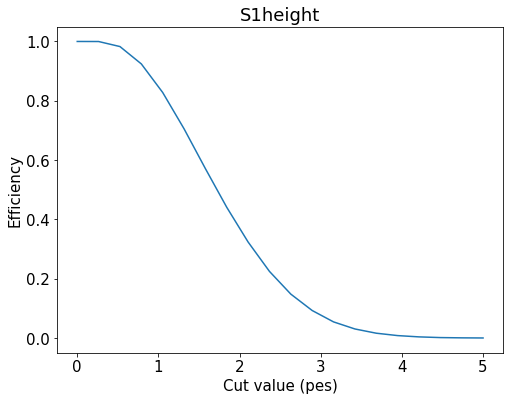

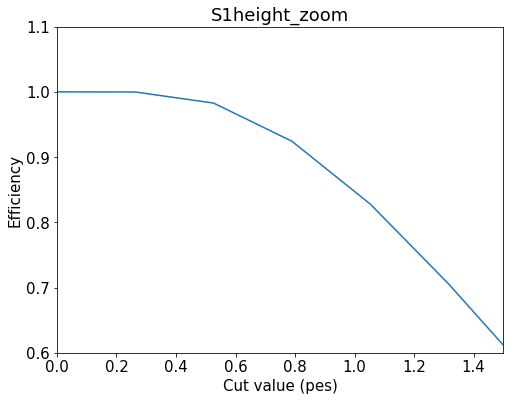

In [11]:
cuts = np.linspace(0, 5, 20)
vals = lmap(get("S1h"), data.evts)
effs = np.array([np.count_nonzero(vals >= cut) for cut in cuts]) / n0 

plot(cuts, effs)
labels("Cut value (pes)", "Efficiency")
save("S1height")

plot(cuts, effs)
plt.xlim(0, 1.5)
plt.ylim(.6, 1.1)
labels("Cut value (pes)", "Efficiency")
save("S1height_zoom")

## S1 efficiency as a function of S1 width

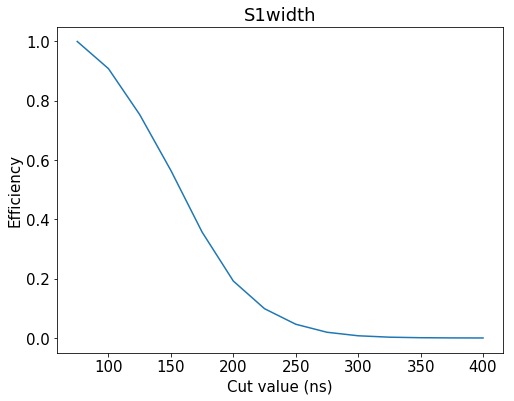

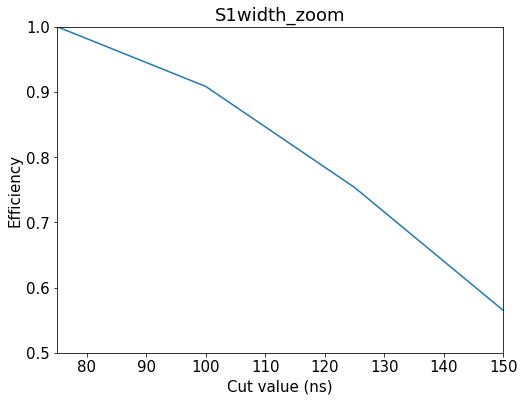

In [12]:
cuts = np.linspace(75, 425, 14, endpoint=False)
vals = lmap(get("S1w"), data.evts)
effs = np.array([np.count_nonzero(vals >= cut) for cut in cuts]) / n0 

plot(cuts, effs)
labels("Cut value (ns)", "Efficiency")
save("S1width")

plot(cuts, effs)
plt.xlim(75, 150)
plt.ylim(.5, 1)
labels("Cut value (ns)", "Efficiency")
save("S1width_zoom")

## S1 efficiency as a function of S1 energy

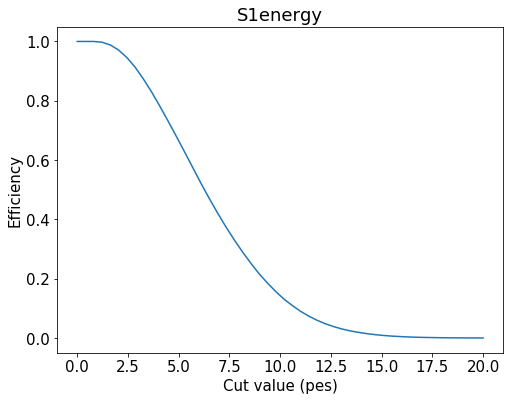

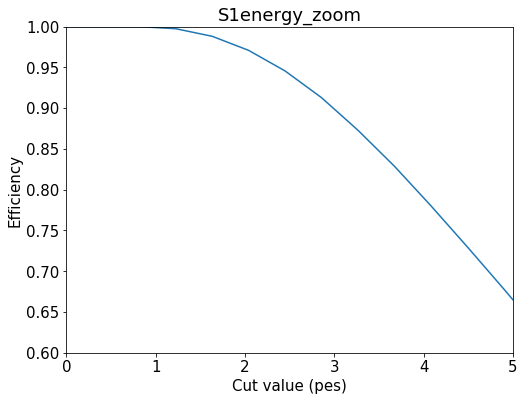

In [13]:
cuts = np.linspace(0, 20, 50)
vals = lmap(get("S1i"), data.evts)
effs = np.array([np.count_nonzero(vals >= cut) for cut in cuts]) / n0 

plot(cuts, effs)
labels("Cut value (pes)", "Efficiency")
save("S1energy")

plot(cuts, effs)
plt.xlim(0, 5)
plt.ylim(.6, 1)
labels("Cut value (pes)", "Efficiency")
save("S1energy_zoom")

# S2

In [14]:
data = haveS2
n0   = data.evts.size

## S2 efficiency as a function of S2 width

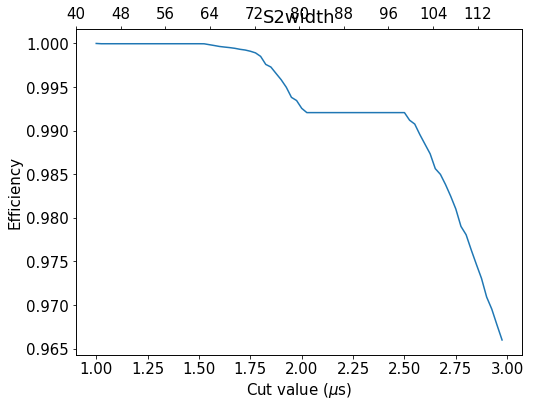

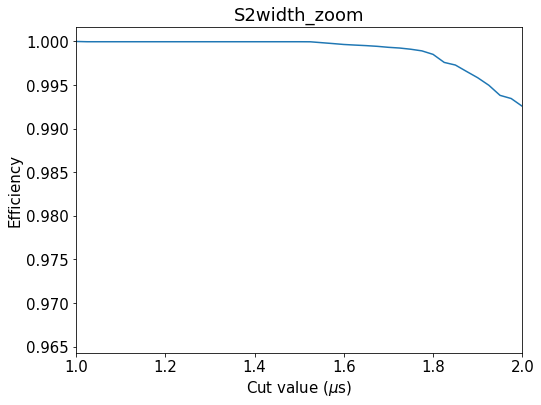

In [15]:
nmin, nmax = 40, 120
lmin, lmax = nmin*25/1e3, nmax*25/1e3
cuts = np.linspace(lmin, lmax, 80, endpoint=False)
vals = lmap(get("S2w"), data.evts)
effs = np.array([np.count_nonzero(vals >= cut) for cut in cuts]) / n0 

plot(cuts, effs)
labels("Cut value ($\mu$s)", "Efficiency")
ax = plt.twiny()
ax.set_xlim(nmin, nmax)
ax.set_xticks(np.linspace(nmin, nmax, 10, endpoint=False))
save("S2width")

plot(cuts, effs)
plt.xlim(lmin, lmin * 2)
#plt.ylim(.6, 1.1)
labels("Cut value ($\mu$s)", "Efficiency")
save("S2width_zoom")

## S2 efficiency as a function of S2 charge

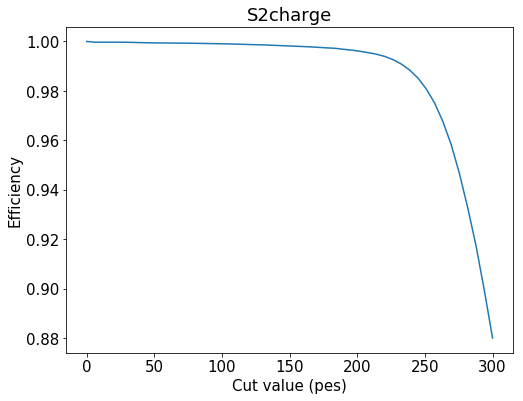

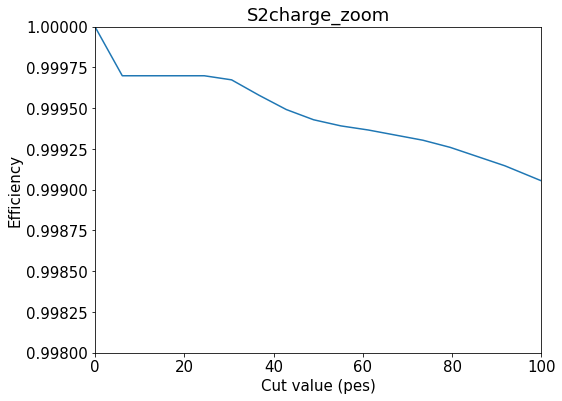

In [16]:
cuts = np.linspace(0, 300, 50)
vals = lmap(get("Q"), data.evts)
effs = np.array([np.count_nonzero(vals >= cut) for cut in cuts]) / n0 

plot(cuts, effs)
labels("Cut value (pes)", "Efficiency")
save("S2charge")

plot(cuts, effs)
plt.xlim(0, 100)
plt.ylim(.998, 1)
labels("Cut value (pes)", "Efficiency")
save("S2charge_zoom")

# Geometrical efficiencies

In [17]:
data = haveS12
n0 = data.evts.size

/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/ipykernel/__main__.py:4: RuntimeWarning: invalid value encountered in greater


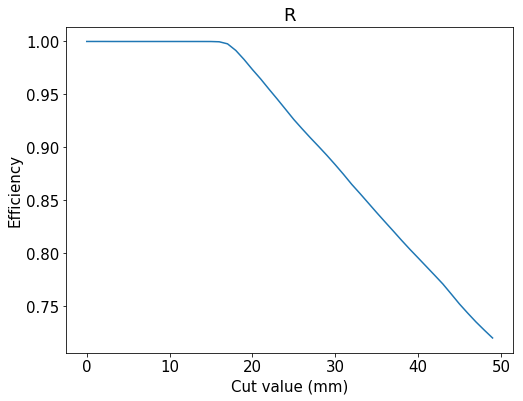

In [18]:
cuts = np.linspace(0, 50, 50, endpoint=False)
rmax = 215.
vals = lmap(get("R"), data.evts)
effs = np.array([np.count_nonzero(vals < cut) for cut in rmax - cuts]) / n0 

plot(cuts, effs)
labels("Cut value (mm)", "Efficiency")
save("R")

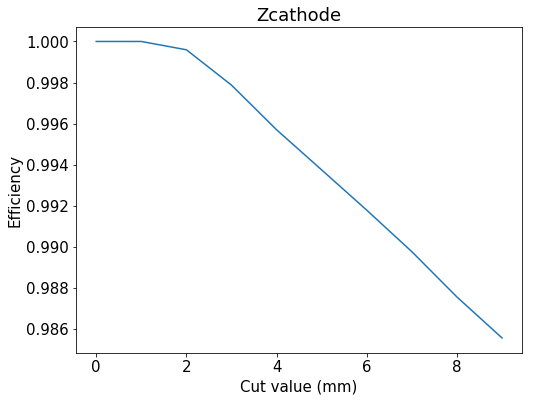

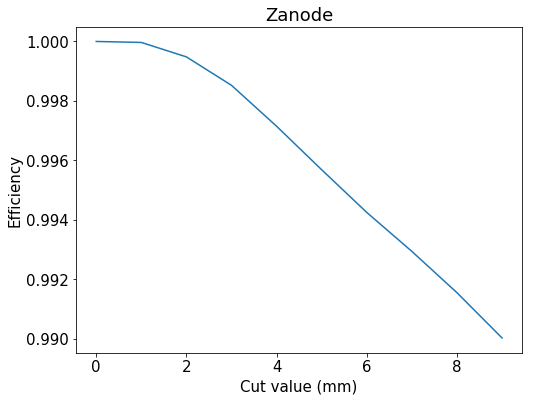

In [19]:
cuts = np.linspace(0, 10, 10, endpoint=False)
zmax = 535
vals = lmap(get("Z"), data.evts)
effs = np.array([np.count_nonzero(vals < cut) for cut in zmax - cuts]) / n0 

plot(cuts, effs)
labels("Cut value (mm)", "Efficiency")
save("Zcathode")

effs = np.array([np.count_nonzero(vals > cut) for cut in cuts]) / n0 

plot(cuts, effs)
labels("Cut value (mm)", "Efficiency")
save("Zanode")

## Number of SiPMs touched

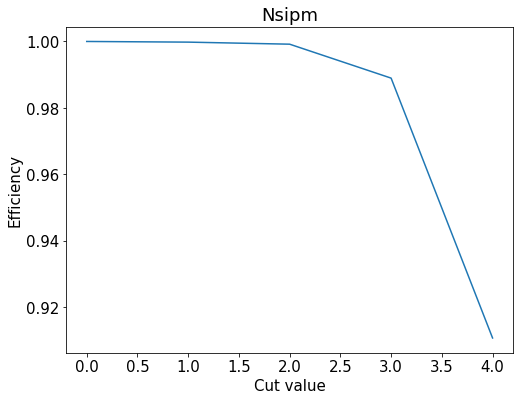

In [20]:
cuts = np.linspace(0, 5, 5, endpoint=False)
vals = lmap(get("Nsipm"), data.evts)
effs = np.array([np.count_nonzero(vals >= cut) for cut in cuts]) / n0 

plot(cuts, effs)
labels("Cut value", "Efficiency")
save("Nsipm")

# Nsipm efficiency as a function of their charge

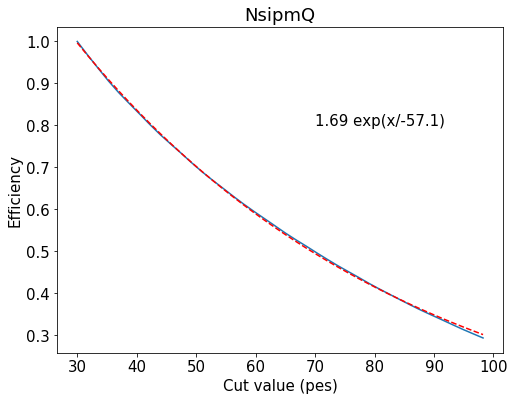

In [21]:
cuts  = np.linspace(30, 100, 40, endpoint=False)
vals  = lmap(get("Qsipm"), data.evts)
nsipm = lmap(get("Nsipm"), data.evts) 
effs  = np.array([np.mean([np.count_nonzero(qs >= cut)/n[0]
                           for qs, n in zip(vals, nsipm) if any(n)])
                  for cut in cuts])

plot(cuts, effs)
f = fitf.fit(fitf.expo, cuts, effs, (1,-50))
plt.plot(cuts, f.fn(cuts), "r--")
plt.text(70, 0.8, "{:.3g} exp(x/{:.3g})".format(*f.values))
labels("Cut value (pes)", "Efficiency")
save("NsipmQ")